### Imports

In [98]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# we copy and mutate dataframes, which causes warnings, however we are aware of this
import warnings
warnings.filterwarnings('ignore')

For this analysis we use data, which we exported from our otree server.  
The data was collected from the 21.08.2020 to the 26.08.2020 12:00.  
 
We start by loading that data into a dataframe from pandas.

In [100]:
df = pd.read_csv("data28aug12uhr.csv")

# Data Preparation

First we rename the most important data columns.

In [101]:
df['id']=df['participant.id_in_session']
df['group']=df['bms_experiment.1.player.trans_cond']
df['age']=df['bms_experiment.1.player.age']
df['gender']=df['bms_experiment.1.player.gender']
df['installed']=df['bms_experiment.1.player.installed']
df['per_und_r1']=df['bms_experiment.1.player.understanding']
df['per_und_r2']=df['bms_experiment.2.player.understanding']
df['color_try1']=df['bms_experiment.1.player.attentive_1']
df['color_try2']=df['bms_experiment.1.player.attentive_2']
df['finished']=((df['bms_experiment.1.player.finished'] == 1.0) | (df['bms_experiment.2.player.finished'] == 1.0) )

We sort out all participants who did not finish the whole survey.

In [102]:
df = df[df['finished'] == True] 

### Actual Understanding Calculation
Here we calculate the actual understanding, which is determined by four multiple-choice-questions.  
The participants will get one point per possible answer, if they answered according to the solution. This leads to four possible points per question with four questions in total.  
There also was the possibility to answer with "I don't know". If this is the case the participant will automatically get zero points for the question, regardless the other answers.

In [103]:
# initialize columns for each question

# round 1
df['q1_r1']= 0
df['q2_r1']= 0
df['q3_r1']= 0
df['q4_r1']= 0

#round 2
df['q1_r2']= 0
df['q2_r2']= 0
df['q3_r2']= 0
df['q4_r2']= 0

# 1 => answer is correct
# 0 => answer is wrong
solutions = [[0,0,1,0],[0,0,0,1],[1,0,0,1],[0,0,0,1]]

# we iterate through all rounds (1 & 2) and all questions (1 - 4)
for roundnumber in range(1,3):
    for question in range(1,5):
        for i in df.T:
            question_score = 0
            # if the participants answered "I don't know, we set the question_score to zero"
            if df['bms_experiment.{0}.player.q{1}_a5'.format(roundnumber,question)][i] == 1:
                question_score = 0
            else:
                # we iterate through all possible answers and increase the question score by one for each correct question
                for answer in range(1,5):
                    if df['bms_experiment.{0}.player.q{1}_a{2}'.format(roundnumber,question,answer)][i] == solutions[question-1][answer-1]:
                        question_score = question_score + 1 
                # after calculating the question score we set it accordingly in the dataframe 
                df['q{0}_r{1}'.format(question,roundnumber)][i]=question_score

### Check for consistency in inverted questions
All of our trust questions also have an inverted form. We did this to be aware of people, who simply answer the survey randomly.  
Here we set a column called "invertedCheck" to False if the participant answered strongly contradictory.  
By strongly contradictory we mean that the participant answered "Fully agree" to both the original as well as the negated question. 
Technically this means that the participant answered 5 to both questions. We calculate the invertedCheck by calculating the average of both answers. If this average is equal to 1 or 5, this means that the participant answered strongly contradictory.

In [104]:
# initialize column for invertedCheck
df['invertedCheck'] = True

# iterate through each round and each trust aspect
for roundnumber in range(1,3):
    for trustAspect in ['competence','benevolence','no_central_entity','anonymity','no_tracking','unlinkabilty']:
        for i in df.T:
            if (((df['bms_experiment.{0}.player.{1}'.format(roundnumber, trustAspect)][i] +
                  df['bms_experiment.{0}.player.{1}_neg'.format(roundnumber, trustAspect)][i]) / 2) < 2) | \
                    (((df['bms_experiment.{0}.player.{1}'.format(roundnumber, trustAspect)][i] +
                       df['bms_experiment.{0}.player.{1}_neg'.format(roundnumber, trustAspect)][i]) / 2) > 4):
                df['invertedCheck'][i]= False

### Calculate trust
Here we calculate trust values for competence and benevolence, as well as the subaspects of integrity.  
For each value we have exactly one question and one negated question. We calculate the corresponding value through the average of the answer to the original question and the negated question. Before doing that we invert the answer to the negated question. This means that if the answer to the negated question is 5, we change it 1. (5->1, 4->2, 3->3, ...)

In [105]:
# iterate through each round and each trust aspect
for roundnumber in range(1,3):
    for trustAspect in ['competence','benevolence','no_central_entity','anonymity','no_tracking','unlinkabilty']:
        df['{0}_r{1}'.format(trustAspect,roundnumber)]= 100 #column erstellen
        for i in df.T:
            aspect = df['bms_experiment.{0}.player.{1}'.format(roundnumber,trustAspect)][i]
            # invert the negated question
            aspect_neg_inverted = abs(df['bms_experiment.{0}.player.{1}_neg'.format(roundnumber,trustAspect)][i]-6)
            # calculate question and save to dataframe
            df['{0}_r{1}'.format(trustAspect,roundnumber)][i] = (aspect + aspect_neg_inverted)/2.0


### Drop all irrelevant columns

In [106]:
df.drop(['participant.id_in_session', 'bms_experiment.1.player.trans_cond',
       'bms_experiment.1.player.age', 'bms_experiment.1.player.gender',
       'bms_experiment.1.player.installed',
       'bms_experiment.1.player.understanding',
       'bms_experiment.1.player.attentive_1',
       'bms_experiment.1.player.attentive_2',
       'bms_experiment.1.player.finished',
       'bms_experiment.2.player.understanding',
       'bms_experiment.2.player.finished',
       'participant._is_bot','participant.code','participant.label','participant._index_in_pages',
       'participant._max_page_index', 'participant._current_app_name',
       'participant._current_page_name', 'participant.time_started',
       'participant.visited','participant.mturk_worker_id',
       'participant.mturk_assignment_id', 'participant.payoff',
       'participant.payoff_plus_participation_fee', 'session.code',
       'session.label', 'session.mturk_HITId', 'session.mturk_HITGroupId',
       'session.comment', 'session.is_demo',
       'session.config.participation_fee',
       'session.config.real_world_currency_per_point','bms_experiment.1.player.payoff','bms_experiment.2.player.payoff','bms_experiment.1.player.id_in_group',
       'bms_experiment.1.group.id_in_subsession',
       'bms_experiment.1.subsession.round_number',
       'bms_experiment.2.player.id_in_group',
       'bms_experiment.2.player.trans_cond','bms_experiment.2.group.id_in_subsession',
       'bms_experiment.2.subsession.round_number','bms_experiment.2.player.age',
       'bms_experiment.2.player.gender', 'bms_experiment.2.player.installed',
       'bms_experiment.2.player.attentive_1',
       'bms_experiment.2.player.attentive_2',
       'bms_experiment.1.player.q1_a1', 'bms_experiment.1.player.q1_a2',
       'bms_experiment.1.player.q1_a3', 'bms_experiment.1.player.q1_a4',
       'bms_experiment.1.player.q1_a5', 'bms_experiment.1.player.q2_a1',
       'bms_experiment.1.player.q2_a2', 'bms_experiment.1.player.q2_a3',
       'bms_experiment.1.player.q2_a4', 'bms_experiment.1.player.q2_a5',
       'bms_experiment.1.player.q3_a1', 'bms_experiment.1.player.q3_a2',
       'bms_experiment.1.player.q3_a3', 'bms_experiment.1.player.q3_a4',
       'bms_experiment.1.player.q3_a5', 'bms_experiment.1.player.q4_a1',
       'bms_experiment.1.player.q4_a2', 'bms_experiment.1.player.q4_a3',
       'bms_experiment.1.player.q4_a4', 'bms_experiment.1.player.q4_a5',
       'bms_experiment.2.player.q1_a1', 'bms_experiment.2.player.q1_a2',
       'bms_experiment.2.player.q1_a3', 'bms_experiment.2.player.q1_a4',
       'bms_experiment.2.player.q1_a5', 'bms_experiment.2.player.q2_a1',
       'bms_experiment.2.player.q2_a2', 'bms_experiment.2.player.q2_a3',
       'bms_experiment.2.player.q2_a4', 'bms_experiment.2.player.q2_a5',
       'bms_experiment.2.player.q3_a1', 'bms_experiment.2.player.q3_a2',
       'bms_experiment.2.player.q3_a3', 'bms_experiment.2.player.q3_a4',
       'bms_experiment.2.player.q3_a5', 'bms_experiment.2.player.q4_a1',
       'bms_experiment.2.player.q4_a2', 'bms_experiment.2.player.q4_a3',
       'bms_experiment.2.player.q4_a4', 'bms_experiment.2.player.q4_a5',
       'bms_experiment.1.player.competence',
       'bms_experiment.1.player.competence_neg',
       'bms_experiment.1.player.benevolence',
       'bms_experiment.1.player.benevolence_neg',
       'bms_experiment.1.player.no_central_entity',
       'bms_experiment.1.player.no_central_entity_neg',
       'bms_experiment.1.player.anonymity',
       'bms_experiment.1.player.anonymity_neg',
       'bms_experiment.1.player.no_tracking',
       'bms_experiment.1.player.no_tracking_neg',
       'bms_experiment.1.player.unlinkabilty',
       'bms_experiment.1.player.unlinkabilty_neg',
        'bms_experiment.2.player.competence',
       'bms_experiment.2.player.competence_neg',
       'bms_experiment.2.player.benevolence',
       'bms_experiment.2.player.benevolence_neg',
       'bms_experiment.2.player.no_central_entity',
       'bms_experiment.2.player.no_central_entity_neg',
       'bms_experiment.2.player.anonymity',
       'bms_experiment.2.player.anonymity_neg',
       'bms_experiment.2.player.no_tracking',
       'bms_experiment.2.player.no_tracking_neg',
       'bms_experiment.2.player.unlinkabilty',
       'bms_experiment.2.player.unlinkabilty_neg',], axis=1, inplace=True)

### Color check
In our survey we added a simple piece of information in the text. It said "The color is yellow".  
After the participants read that text, they had to replicate this information. If they failed the first time, they were asked to read the text again and had another chance to replicate. If they failed a second time we will sort them out.  
The control group had no text and thereby they never failed this test.

In [107]:
df['color_check'] = (df['group'] == 'no') | ( # set to true if group is control group
            (df['group'] != 'no') & ((df['color_try1'] == 'yellow') | (df['color_try2'] == 'yellow'))) # set to true if participant answered correctly

In [108]:
df_new = df

## Aggregation of values

### Calculation of actual understanding and integrity
We calculate the actual understanding (in both rounds) through the average the points for each question.  
Integrity will also be calculated through the average of each subaspect.

In [109]:
df_new['act_und_r1']=(df_new['q1_r1']+df_new['q2_r1']+df_new['q3_r1']+df_new['q4_r1'])/4
df_new['act_und_r2']=(df_new['q1_r2']+df_new['q2_r2']+df_new['q3_r2']+df_new['q4_r2'])/4
df_new['integrity_r1']=(df_new['no_central_entity_r1']+df_new['anonymity_r1']+df_new['no_tracking_r1']+df_new['unlinkabilty_r1'])/4
df_new['integrity_r2']=(df_new['no_central_entity_r2']+df_new['anonymity_r2']+df_new['no_tracking_r2']+df_new['unlinkabilty_r2'])/4

# drop the columns which were used for calculation
df_new.drop(['q1_r1','q2_r1', 'q3_r1', 'q4_r1', 'q1_r2', 'q2_r2', 'q3_r2', 'q4_r2',
        'no_central_entity_r1', 'anonymity_r1', 'no_tracking_r1','unlinkabilty_r1',
        'no_central_entity_r2', 'anonymity_r2', 'no_tracking_r2',
       'unlinkabilty_r2'], axis=1, inplace=True)

### Calculation of trust
We calculate trust through the average of competence, benevolence and integrity.

In [110]:
# we create new columns in which we can store trust aspects for both groups
df_new['competence']=0
df_new['benevolence']=0
df_new['integrity']=0

for i in df_new.T:
    if df_new['group'][i] == 'no':
        df_new['competence'][i]=df_new['competence_r1'][i]
        df_new['benevolence'][i]=df_new['benevolence_r1'][i]
        df_new['integrity'][i]=df_new['integrity_r1'][i]
    else:
        df_new['competence'][i]=df_new['competence_r2'][i]
        df_new['benevolence'][i]=df_new['benevolence_r2'][i]
        df_new['integrity'][i]=df_new['integrity_r2'][i]
        

df_new['trust']=(df_new['competence']+df_new['benevolence']+df_new['integrity'])/3

# drop the columns used for calculation
df_new.drop(['competence_r1', 'benevolence_r1', 'competence_r2', 'benevolence_r2','integrity_r1', 'integrity_r2'], axis=1, inplace=True)

In [111]:
total = df_new['id'].count()
failed_color = df_new[df_new['color_check']==False]['id'].count()
valid = total-failed_color
print("""total number of participants: {}
      failed the color check: {}
    
number of valid participants: {}
""".format(total, failed_color, valid))

total number of participants: 80
      failed the color check: 7
    
number of valid participants: 73



In [112]:
df_clean = df_new[(df_new['finished']==True)]

# Data Analysis
First we take a look at some basic information about our participants.

In [113]:
num_female = df_new[df_new['gender'] == 0]['id'].count()
num_male = df_new[df_new['gender'] == 1]['id'].count()
num_diverse = df_new[df_new['gender'] == 2]['id'].count()

print("""average age:
~{:.2f}

percentage of participants, who have the app installed:
{:.2f}%

female:  {:.2f}%
male:    {:.2f}%
diverse: {:.2f}%
""".format(df_new['age'].mean(),
           df_new['installed'].mean()*100,
           num_female/total*100,
           num_male/total*100,
           num_diverse/total*100
          ))

average age:
~25.77

percentage of participants, who have the app installed:
80.00%

female:  43.75%
male:    56.25%
diverse: 0.00%



### Check for bias

In [114]:
tr_no = df_clean.loc[df_clean['group']=='no']['act_und_r1']
tr_brief = df_clean.loc[df_clean['group']=='brief']['act_und_r1']
tr_detail = df_clean.loc[df_clean['group']!='detail']['act_und_r1']

print("""Mean actual understanding of participants at the start of the experiment in the...
... control group:    ~{:.4f}
... brief group:    ~{:.4f}
... detailed group:    ~{:.4f}

""".format(np.mean(tr_no), np.mean(tr_brief), np.mean(tr_detail)))

Mean actual understanding of participants at the start of the experiment in the...
... control group:    ~2.9310
... brief group:    ~2.8173
... detailed group:    ~2.9031




In [115]:
MWU=stats.mannwhitneyu(tr_no,tr_brief,alternative='two-sided')
print("control group vs. brief group \n", MWU)

control group vs. brief group 
 MannwhitneyuResult(statistic=408.5, pvalue=0.5992136527033531)


In [116]:
MWU=stats.mannwhitneyu(tr_no,tr_detail,alternative='two-sided')
print("control group vs. detail group \n", MWU)

control group vs. detail group 
 MannwhitneyuResult(statistic=1173.0, pvalue=0.9312988168060065)


In [117]:
MWU=stats.mannwhitneyu(tr_brief,tr_detail,alternative='two-sided')
print("brief group vs. detail group \n", MWU)

brief group vs. detail group 
 MannwhitneyuResult(statistic=964.0, pvalue=0.5769980753258837)


Eventhough there are differences in the mean of the actual understanding at the begin of the experiment between the different groups. However, these differences are not statistically significant.

### [H1] "Users will have a better understanding of the system when provided with an explanation of its   functionality."
#### Control vs Treatment
##### Actual Understanding
We retrieve the actual understanding of the control group and the actual understanding of the treatment groups after the treatment. After that we will check if there is a statistically significant difference between the control group and the first treatment group as well as the control group and the second treatment group.

In [118]:
tr1=df_clean.loc[df_clean['group']=='no']['act_und_r1']
tr2=df_clean.loc[df_clean['group']=='brief']['act_und_r2']
tr3=df_clean.loc[df_clean['group']=='detailed']['act_und_r2']

print("""Number of participants in the...
... control group:    {}
... 'brief' group:    {}
... 'detailed' group: {}

Mean actual understanding of participants in the...
... control group:    ~{:.4f}
... 'brief' group:    ~{:.4f}
... 'detailed' group: ~{:.4f}

""".format(len(tr1), len(tr2), len(tr2),
          np.mean(tr1), np.mean(tr2), np.mean(tr3)
          ))

Number of participants in the...
... control group:    29
... 'brief' group:    26
... 'detailed' group: 26

Mean actual understanding of participants in the...
... control group:    ~2.9310
... 'brief' group:    ~3.2308
... 'detailed' group: ~3.2800




Now we run a MWU-Test, because it is non-parametic.

In [119]:
MWU=stats.mannwhitneyu(tr1,tr2,alternative='two-sided')
print("control group vs. 'brief' group \n", MWU)
print("")
MWU=stats.mannwhitneyu(tr1,tr3,alternative='two-sided')
print("control group vs. 'detailed' group \n", MWU)

control group vs. 'brief' group 
 MannwhitneyuResult(statistic=294.0, pvalue=0.16083921426079806)

control group vs. 'detailed' group 
 MannwhitneyuResult(statistic=273.0, pvalue=0.11805230895032581)


##### Perceived Understanding
We repeat the process for perceived understanding

In [120]:
ptr1=df_clean.loc[df_clean['group']=='no']['per_und_r1']
ptr2=df_clean.loc[df_clean['group']=='brief']['per_und_r2']
ptr3=df_clean.loc[df_clean['group']=='detailed']['per_und_r2']

print("""
Mean perceived understanding of participants in the...
... control group:    ~{:.4f}
... 'brief' group:    ~{:.4f}
... 'detailed' group: ~{:.4f}

""".format(np.mean(ptr1), np.mean(ptr2), np.mean(ptr3)))

MWU=stats.mannwhitneyu(tr1,tr2,alternative='two-sided')
print("control group vs. 'brief' group \n", MWU)
print("")
MWU=stats.mannwhitneyu(tr1,tr3,alternative='two-sided')
print("control group vs. 'detailed' group \n", MWU)


Mean perceived understanding of participants in the...
... control group:    ~3.5172
... 'brief' group:    ~3.6923
... 'detailed' group: ~4.0000


control group vs. 'brief' group 
 MannwhitneyuResult(statistic=294.0, pvalue=0.16083921426079806)

control group vs. 'detailed' group 
 MannwhitneyuResult(statistic=273.0, pvalue=0.11805230895032581)


#### Treatment before vs after
We can also compare the trust inside the treatment groups, because we collected data on understanding before the texts and after the texts.
##### Actual Understanding

In [121]:
before=df_clean.loc[(df_clean['group']=='brief') | (df_clean['group']=='detailed')]['act_und_r1']
after=df_clean.loc[(df_clean['group']=='brief') | (df_clean['group']=='detailed')]['act_und_r2']

print("""
Mean actual understanding of participants...
... before the treatment:    ~{:.4f}
... after the treatment:     ~{:.4f}

""".format(np.mean(before), np.mean(after)))


Mean actual understanding of participants...
... before the treatment:    ~2.8873
... after the treatment:     ~3.2549




In [122]:
#comparing actual understanding before and after reading the text
MWU=stats.mannwhitneyu(before,after,alternative='two-sided') #MWU Test, non-parametic for independent samples
print("before treatment vs. after treatment \n", MWU)

before treatment vs. after treatment 
 MannwhitneyuResult(statistic=976.5, pvalue=0.028734974440313095)


##### Perceived Understanding

In [123]:
before=df_clean.loc[(df_clean['group']=='brief') | (df_clean['group']=='detailed')]['per_und_r1']
after=df_clean.loc[(df_clean['group']=='brief') | (df_clean['group']=='detailed')]['per_und_r2']

print("""
Mean actual understanding of participants...
... before the treatment:    ~{:.4f}
... after the treatment:     ~{:.4f}

""".format(np.mean(before), np.mean(after)))


Mean actual understanding of participants...
... before the treatment:    ~3.5882
... after the treatment:     ~3.8431




In [124]:
MWU=stats.mannwhitneyu(before,after,alternative='two-sided') #MWU Test, non-parametic for independent samples
print("before treatment vs. after treatment \n", MWU)

before treatment vs. after treatment 
 MannwhitneyuResult(statistic=1146.0, pvalue=0.2791108171496022)


### [H2] Understandable explanations of the app’s functionality will increase trust.
We will compare the trust of the control group with the trust of the treatment groups. Our hypothesis states that the trust should be significantly higher in the treatment groups.

In [125]:
df_treatment = df_clean.loc[(df_clean['group']=='brief') | (df_clean['group']=='detailed')]

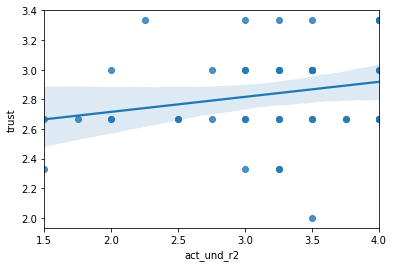

In [126]:
sns.regplot(x='act_und_r2', y='trust', data=df_treatment)

In [127]:
tr_trust = df_treatment['trust']
ctrl_trust = df_clean.loc[(df_clean['group']=='no')]['trust']

print("""
Mean trust of participants...
... in the control group:       ~{:.4f}
... im the treatment group:     ~{:.4f}

""".format(np.mean(ctrl_trust), np.mean(tr_trust)))


Mean trust of participants...
... in the control group:       ~2.7931
... im the treatment group:     ~2.8431




In [140]:
MWU=stats.mannwhitneyu(tr_trust,ctrl_trust,alternative='two-sided')
print("trust in control group vs. trust in treatment groups \n", MWU)

trust in control group vs. trust in treatment groups 
 MannwhitneyuResult(statistic=812.0, pvalue=0.44972637242279356)


In [129]:
tr_competence = df_treatment['competence']
ctrl_competence = df_clean.loc[(df_clean['group']=='no')]['competence']

print("""
Mean trust in competence of participants...
... in the control group:       ~{:.4f}
... im the treatment group:     ~{:.4f}

""".format(np.mean(ctrl_competence), np.mean(tr_competence)))


Mean trust in competence of participants...
... in the control group:       ~3.5862
... im the treatment group:     ~3.9804




In [130]:
MWU=stats.mannwhitneyu(tr_competence,ctrl_competence,alternative='two-sided')
print("trust in competence in control group vs. trust in competence in treatment groups \n", MWU)

trust in competence in control group vs. trust in competence in treatment groups 
 MannwhitneyuResult(statistic=932.0, pvalue=0.04159421796533839)


In [131]:
tr_benevolence = df_treatment['benevolence']
ctrl_benevolence = df_clean.loc[(df_clean['group']=='no')]['benevolence']

print("""
Mean trust in benevolence of participants...
... in the control group:       ~{:.4f}
... im the treatment group:     ~{:.4f}

Belief in benevolence actually decreases!

""".format(np.mean(ctrl_benevolence), np.mean(tr_benevolence)))


Mean trust in benevolence of participants...
... in the control group:       ~1.5517
... im the treatment group:     ~1.2353

Belief in benevolence actually decreases!




In [132]:
MWU=stats.mannwhitneyu(tr_benevolence,ctrl_benevolence,alternative='two-sided') #MWU Test, non-parametic for independent samples
print("trust in benevolence in control group vs. trust in benevolence in treatment groups \n", MWU)

trust in benevolence in control group vs. trust in benevolence in treatment groups 
 MannwhitneyuResult(statistic=594.0, pvalue=0.05930426397572827)


In [133]:
tr_integrity = df_treatment['integrity']
ctrl_integrity = df_clean.loc[(df_clean['group']=='no')]['integrity']

print("""
Mean trust in integrity of participants...
... in the control group:       ~{:.4f}
... im the treatment group:     ~{:.4f}

""".format(np.mean(ctrl_integrity), np.mean(tr_integrity)))


Mean trust in integrity of participants...
... in the control group:       ~3.2414
... im the treatment group:     ~3.3137




In [134]:
MWU=stats.mannwhitneyu(tr_integrity,ctrl_integrity,alternative='two-sided') #MWU Test, non-parametic for independent samples
print("trust in integrity in control group vs. trust in integrity in treatment groups \n", MWU)

trust in integrity in control group vs. trust in integrity in treatment groups 
 MannwhitneyuResult(statistic=800.0, pvalue=0.4660862235395995)


### [H3]: Reasoned explanations of the app’s functionality will increase trust more than other types of transparency features.
We will test whether trust in the treatment group with transparency condition 'detailed' increased more than the treatment group with transparency condition 'brief'.

Because we do not use the control group for this hypothesis we will remove participants, which got the color check wrong.

In [153]:
df_clean_valid = df_clean[df_clean['color_check'] == True]

In [154]:
tr_brief=df_clean_valid.loc[df_clean_valid['group']=='brief']['trust']
tr_detailed=df_clean_valid.loc[df_clean_valid['group']=='detailed']['trust']

print("""Number of participants in the...
... 'brief' group:    {}
... 'detailed' group: {}

Mean trust of participants in the...
... 'brief' group:    ~{:.4f}
... 'detailed' group: ~{:.4f}

""".format(len(tr_brief), len(tr_detailed),
          np.mean(tr_brief), np.mean(tr_detailed),
          ))

Number of participants in the...
... 'brief' group:    24
... 'detailed' group: 20

Mean trust of participants in the...
... 'brief' group:    ~2.8056
... 'detailed' group: ~2.9167




In [155]:
MWU=stats.mannwhitneyu(tr_brief,tr_detailed,alternative='two-sided')
print("trust in 'brief' group vs. trust in 'detailed' group \n", MWU)

trust in 'brief' group vs. trust in 'detailed' group 
 MannwhitneyuResult(statistic=185.5, pvalue=0.17812436038043344)
